In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import odeint
from scipy.io import loadmat
from sklearn import linear_model
from sklearn.neural_network import MLPRegressor
import statistics
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers
from layers import *
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import signal
from models import LSTMEmbedding, LSTMVAEEmbedding #,MLPEmbedding, ETDEmbedding, AMIEmbedding, TICAEmbedding
from regularizers import FNN
import seaborn as sns
sns.set_style("white")
from sklearn.decomposition import PCA, IncrementalPCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def lorenz(x, t, robustness_to_scale=1):
    return [
        robustness_to_scale*10 * (x[1] - x[0]/robustness_to_scale),
        x[0]/robustness_to_scale * (28 - x[2]) - x[1],
        x[0]/robustness_to_scale * x[1] - 8 / 3 * x[2],
    ]

In [3]:
# Numerical integrating a trajectory
# Choice of dt to ba a fractional value of the value dictated by mutual information
dt = 0.004 
num_steps =500
t_train = np.arange(0, num_steps, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_dot_train_measured = np.array(
    [lorenz(x_train[i], 0) for i in range(t_train.size)]
)

adjustement=10
dt_adjusted=dt*adjustement
obs = x_train[::adjustement,:]
obs_x = obs[:,0]
obs_y = obs[:,1]
obs_z = obs[:,2]

In [32]:
obs_x.shape

(12500,)

In [18]:
# creating Takens embedding
def takens_embedding(obs_x, delay=1, n=6):
    embeddings = []
    for i in range(n):
        embeddings = embeddings + [[obs_x[(i)*delay:(-n+i)*delay]]]
    return np.concatenate(embeddings,axis=0)




In [33]:
takens = takens_embedding(obs_x,n=6).T
takens.shape

(12494, 6)

In [35]:
b = 6
pca = PCA(n_components=b)
pca.fit(takens)
embeddings =pca.transform(takens)

In [21]:
embeddings.shape

(12494, 6)

Text(0, 0.5, '$e_2(t)$')

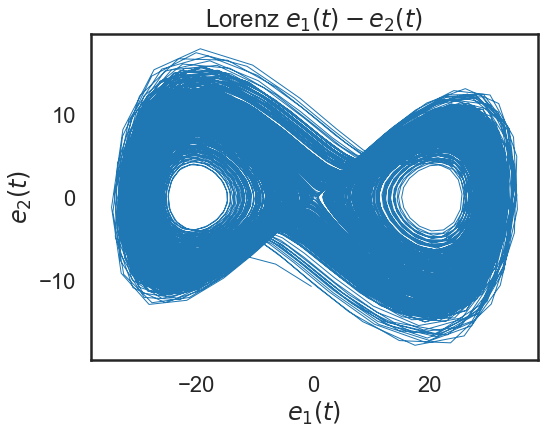

In [24]:
sns.set_context("poster")
plt.figure(figsize=(8,6))
plt.plot(embeddings[:,0], embeddings[:,1], linewidth=1)
plt.title("Lorenz $e_1(t)-e_2(t)$")
plt.xlabel("$e_1(t)$")
plt.ylabel("$e_2(t)$")

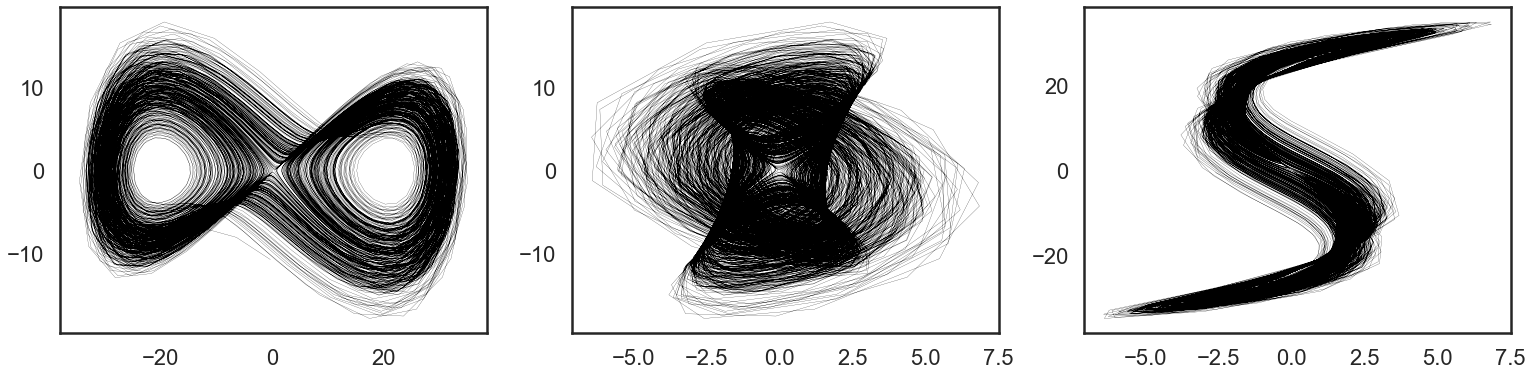

In [23]:
sns.set_context("poster")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
ax[0].plot(embeddings[:,0], embeddings[:,1], 'k', linewidth=.2)
ax[1].plot(embeddings[:,2], embeddings[:,1], 'k', linewidth=.2)
ax[2].plot(embeddings[:,2], embeddings[:,0], 'k', linewidth=.2)

In [36]:
#%% Linearly decode embeddings into original space
reg = linear_model.LinearRegression()
# reg.fit(coords_lstm, obs[10:])
target= np.array([obs_x ,obs_y, obs_z]).T
reg.fit(embeddings, target[3:-3])
x_pred = reg.predict(embeddings)

In [56]:
print(reg.coef_)

[[-4.28398560e-01 -1.36857414e-01 -4.37415685e-01 -3.19726446e-01
  -3.53455155e-01  6.15838204e-01]
 [-4.07867433e-01 -8.10847883e-01  7.20493428e-02 -1.70203329e+00
   1.55520027e+00  2.30858512e+00]
 [-2.92419412e-03  2.91995093e-03 -6.67377295e-04  6.00154322e-03
   6.84289922e-02  2.96444824e-01]]


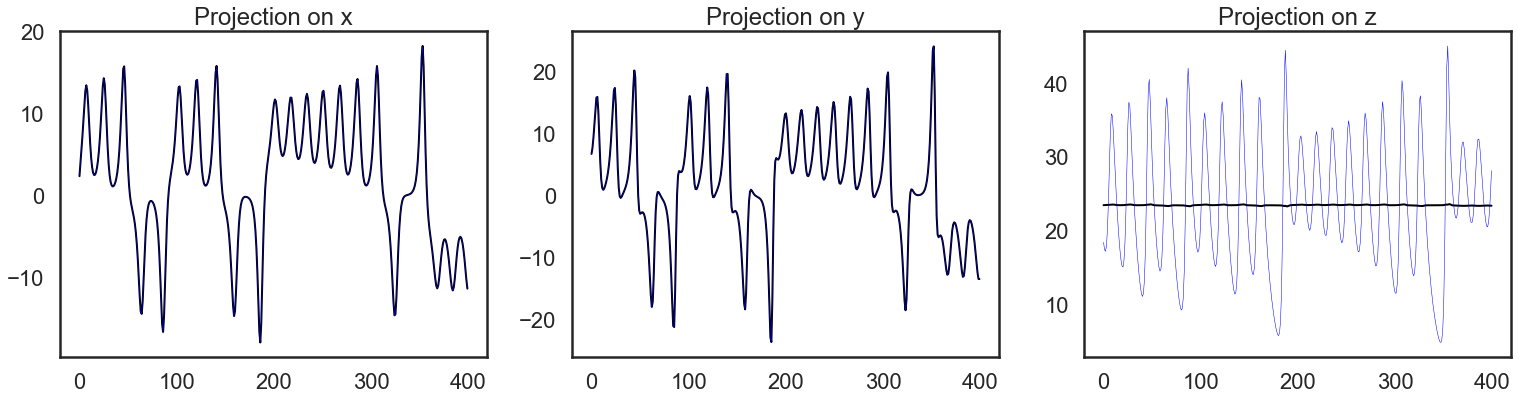

In [55]:
sns.set_context("poster")
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,6))
ax[0].set_title('Projection on x')
ax[0].plot(x_pred[:400,0], 'k', linewidth=2)
ax[0].plot(obs_x[3:403], 'b', linewidth=.5)
ax[1].set_title('Projection on y')
ax[1].plot(x_pred[:400,1], 'k', linewidth=2)
ax[1].plot(obs_y[3:403], 'b', linewidth=.5)
ax[2].set_title('Projection on z')
ax[2].plot(x_pred[:400,2], 'k', linewidth=2)
ax[2].plot(obs_z[3:403], 'b', linewidth=.5)

## Bad $\tau$, too large

In [28]:
takens = takens_embedding(obs_x,n=6,delay=10).T

In [29]:
b = 6
pca = PCA(n_components=b)
pca.fit(takens)
embeddings =pca.transform(takens)

Text(0, 0.5, '$e_2(t)$')

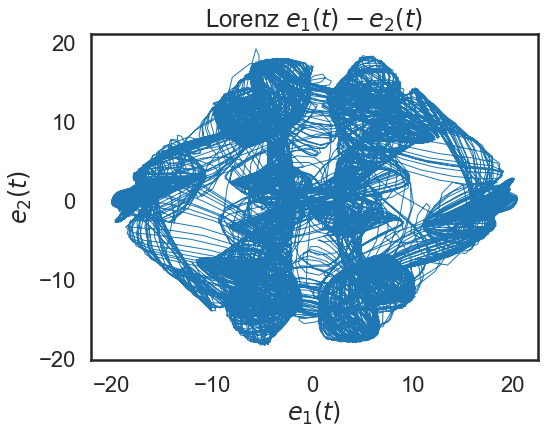

In [30]:
sns.set_context("poster")
plt.figure(figsize=(8,6))
plt.plot(embeddings[:,0], embeddings[:,1], linewidth=1)
plt.title("Lorenz $e_1(t)-e_2(t)$")
plt.xlabel("$e_1(t)$")
plt.ylabel("$e_2(t)$")